In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from math import sqrt


In [31]:
class MyRegression:
    """ Class containing fit, predict and output methods for linear regression. 
    
    Input:
    model_object: sklearn model object
    data dictionary with the following keys
    x_train: 1D or 2D array
    x_test: 1D or 2D array
    y_train: 1D array
    y_test: 1D array 
    """
    
    def __init__(self, data, model_object):
        self.model_object = model_object
        self.xtrain = data['x_train']
        self.xtest = data['x_test']
        self.ytrain= data['y_train']
        self.ytest = data['y_test']
        self.model = None
        self.ypred = None
    
    def fit(self):
        from sklearn.linear_model import LinearRegression
        self.model = self.model_object.fit(self.xtrain, self.ytrain)
        return self.model
    
    def predict(self):
        if self.model is None:
            self.model = self.model_object.fit(self.xtrain, self.ytrain)
        self.ypred = self.model.predict(xtest)
        return self.ypred
    
    def model_outputs(self):
        if self.model is None:
            self.model = lr.fit(self.xtrain, self.ytrain)
        print(f'Intercept: {self.model.intercept_}\n')
        print(f'Coefficients: {self.model.coef_}\n')
        
class ErrorCalculator:
    """ Class containing error prediction methods for regression models. 
    
    Input:
    model = fitted sklearn model
    data dictionary with the following keys
    x: 1D or 2D array of size (n_samples, n_features)
    y: 1D array of size (n_samples)
    """
        
    def __init__(self, y, ypred):
        self.y = y
        self.ypred = ypred
        self.residuals = None
        
    def residuals_absent(self):
        return self.residuals is None
             
    def get_residuals(self):
        if self.residuals_absent():
            self.residuals = self.ypred - self.y
        
        return self.residuals
        
    def get_mse(self):
        from sklearn import metrics
        mse = metrics.mean_squared_error(self.y, ypred)
        return mse
    
    def get_rmse(self):
        mse = self.get_mse()
        rmse = sqrt(mse)
        return rmse
    
    def print_error(self):
        print("MSE: ", round(self.get_mse(), 2))
        print("RMSE: ", round(self.get_rmse(), 2))

class Plotter:
    """Generic plotting class for residuals.
    """
    def __init__(self, y, ypred):
        self.y = y
        self.ypred = ypred
        self.error_calculator = ErrorCalculator(y, ypred)
        
    def runCalculations(self):
        if self.error_calculator.residuals_absent():
            self.residuals = self.error_calculator.get_residuals()
        return self.residuals
    
    def plot(self):
        self.residuals = self.runCalculations()
        return sns.distplot(self.residuals)
        
        
        
class HistogramPlotter(Plotter):
    """ Class for histograms of residuals
    """

    def plot(self):
        self.residuals = self.runCalculations()
        return sns.distplot(self.residuals)
        

class Scatterplotter(Plotter):
    """ Class for scatterplot of residuals.
    """
    def plot(self):
        self.residuals = self.runCalculations()
        
        vals = {'Residuals': self.residuals, 'Predicted Values': self.ypred, 'Observed Values': self.y}
        resdf = pd.DataFrame(vals)
        
#         ax = sns.regplot(self.ypred, self.y);
#         ax.set(xlabel = 'Predicted Values', ylabel = 'Observed Values')
#         return ax
    
#         ax = sns.residplot(y = 'Residuals',x = 'Predicted Values', data=resdf, lowess = True)
#         return ax
    
    
        g = sns.PairGrid(resdf, y_vars=['Predicted Values'], x_vars=['Residuals', 'Observed Values'], height=4)
        g.map(sns.regplot)
        return g;

#Do the regression using statsmodels to get outliers and influential values easily
def statsmodels_OLS_fit(xtrain, ytrain):
    import statsmodels.api as sm
    xtrain_plusconstant = sm.add_constant(xtrain)
    lr = sm.OLS(ytrain, xtrain_plusconstant)
    model = lr.fit()
    return model
    
class InfluenceCalculator:
    """ Class containing methods for calculating influential values and outliers. 
    
    Input:
    model = fitted sklearn model
    """
        
    def __init__(model):
        self.model = model
    
    def leverage(self):
        influence = self.model.get_influence()
        return influence.hat_matrix_diag
    
    def cooksD(self):
        return self.model.get_influence().cooks_distance


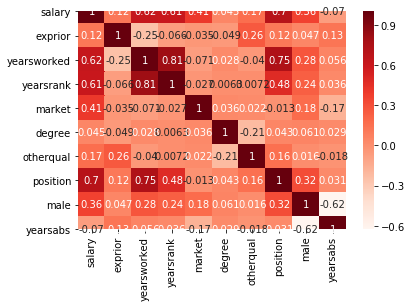

In [3]:
#import salary dataset, removing NAs
df = pd.read_csv("salary.csv")
df = df.dropna()

df.Field = df.Field.astype('category')

#create dummy variables of Field, the only categorical variable
pd.get_dummies(df, drop_first=True)

#visually show high correlation between yearsworked and yearsrank
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

#select two feature sets
x1 = df.drop(columns=['salary'])
x2 = df.drop(columns=['salary', 'yearsrank'])

y = df['salary']

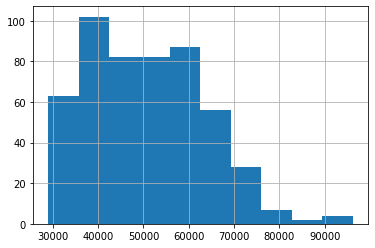

In [5]:
y.hist();

The distribution is skewed - log transform to correct.

mean : 0.0, st dev: 1.0


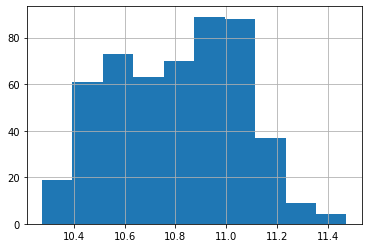

In [6]:
#Scale and transform variables
#standardise data so that mean=0 and SD=1    
standardizer = StandardScaler()   

x1_scaled = standardizer.fit_transform(x1)
x2_scaled = standardizer.fit_transform(x2)

#test that it worked
print(f"mean : {round(np.mean(x1_scaled), 2)}, st dev: {round(np.std(x1_scaled),2)}")

y_log = y.apply(np.log)
y_log.hist();

In [7]:
#do test-train split
x1train, x1test, ytrain, ytest = train_test_split(
    x1_scaled, y_log, test_size = 0.2, random_state = 2)

data = {"x_train": x1train, "x_test": x1test, "y_train": ytrain, "y_test": ytest}

#check that it worked
print("Train and test data shapes:")
for key, value in data.items():
    print(value.shape)
    

Train and test data shapes:
(410, 10)
(103, 10)
(410,)
(103,)


In [8]:
#build model
lr_model1 = MyRegression(data, LinearRegression())
model1 = lr_model1.fit()
lr_model1.model_outputs()

Intercept: 10.808696238883723

Coefficients: [ 0.014508   -0.00711911  0.08092304  0.10081632  0.00092358  0.00741048
  0.13201848  0.00897059 -0.0413046   0.00342296]



MSE:  0.01
RMSE:  0.11


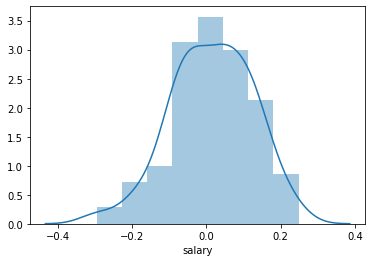

In [34]:
ypred = model1.predict(x1test)
resid = ErrorCalculator(ytest, ypred)
resid.print_error()

histplt = HistogramPlotter(ytest, ypred)
histplt.plot();


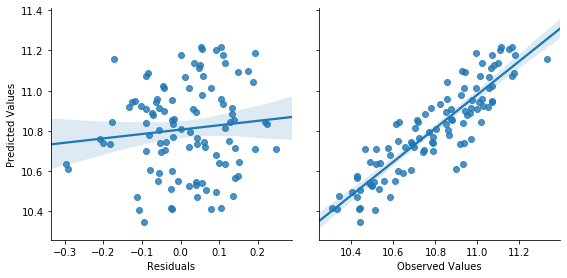

In [33]:
scatter = Scatterplotter(ytest, ypred)
scatter.plot();

## Model 2: No `yearsrank`
Do the same thing for the second model, leaving out years worked in current rank as a predictor

In [ ]:
#data preparation
x2train, x2test, ytrain, ytest = train_test_split(x2_scaled, y_log, test_size = 0.2, random_state = 2)

data2 = {"x_train": x1train, "x_test": x1test, "y_train": ytrain, "y_test": ytest}

#check that it worked
print("Train and test data shapes:")
for key, value in data2.items():
    print(value.shape)
    

In [ ]:
#build model
lr_model2 = my_regression(data2, LinearRegression())
model2 = lr_model2.fit()
lr_model2.model_outputs()

In [ ]:
metrics_m2 =  regression_metrics(model2, data2)
metrics_m2.return_metrics()

The model performs similarly on the test data - the RMSE and MSE values are only sligthly higher (indicating slightly more error) and the variance explained is similar. There is no need to use `yearsrank` as a feature.Let's look at model diagnostics.

In [ ]:
plots_m2 = regression_plots(model2, data2)
plots_m2.predicted_vs_observed();

In [ ]:
plots_m2.resid_vs_predicted();

The residuals are still non-linear: we can try to make this model better. However, there doesn't seem to be a big difference between the model with and without `yearsrank` - we can leave it out.

## BONUS: Influential values

In [ ]:
statsmodel = statsmodels_OLS_fit(x1train, ytrain)

#this works
influence = statsmodel.get_influence()
leverage = influence.hat_matrix_diag

#this doesn't
# influential_values.leverage(statsmodel)